# Projet de Système de Recommandation de Films

Ce document présente une étude approfondie sur la conception et l'évaluation de différents algorithmes de recommandation de films. L'objectif est de comparer plusieurs approches de filtrage collaboratif et de factorisation de matrices, ainsi que des méthodes basées sur la popularité et la similarité entre items. Chaque section détaille la méthodologie, les choix d'implémentation, et propose une analyse critique des résultats obtenus.

Le notebook est structuré comme suit :
- **Chargement et exploration des données** : présentation des jeux de données et analyse descriptive.
- **Préparation des données** : nettoyage, fusion et préparation pour l'entraînement des modèles.
- **Implémentation des algorithmes de recommandation** : filtrage collaboratif (KNN utilisateur et item), factorisation de matrices (SVD, NMF), popularité, et filtrage collaboratif item-item (IBCF).
- **Évaluation et comparaison des performances** : analyse quantitative des résultats.
- **Visualisation et analyse** : illustrations graphiques des distributions et performances.
- **Exemples de recommandations** : génération de recommandations personnalisées pour un utilisateur donné.

Ce rapport vise à fournir une vue d'ensemble complète et reproductible des techniques de recommandation appliquées au domaine cinématographique.

## 1. Chargement et Exploration des Données

Dans cette section, nous importons les jeux de données nécessaires (films, notes, utilisateurs) et réalisons une première exploration. L'objectif est de comprendre la structure des données, d'identifier d'éventuelles valeurs manquantes, et de dégager des tendances générales qui orienteront la suite de l'analyse.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Chargement des données
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
users = pd.read_csv('users.csv')

print('Films :')
display(movies.head())
print('Notes :')
display(ratings.head())
print('Utilisateurs :')
display(users.head())

Films :


,movieId,titles,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Notes :


,userId,movieId,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Utilisateurs :


,userId,gender,age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


**Remarque :**
L'affichage des premières lignes des jeux de données permet de vérifier leur structure et leur contenu. On constate que les fichiers sont correctement chargés et que les colonnes principales (identifiants, titres, genres, notes, etc.) sont présentes. Cela valide la qualité initiale des données pour la suite de l'analyse.

In [23]:
# Analyse rapide
print('Valeurs manquantes dans les films :')
print(movies.isnull().sum())
print('Valeurs manquantes dans les notes :')
print(ratings.isnull().sum())
print('Valeurs manquantes dans les utilisateurs :')
print(users.isnull().sum())
print('\nStatistiques des notes :')
print(ratings['rating'].describe())

Valeurs manquantes dans les films :
movieId    0
titles     0
genres     0
dtype: int64
Valeurs manquantes dans les notes :
userId     0
movieId    0
rating     0
time       0
dtype: int64
Valeurs manquantes dans les utilisateurs :
userId        0
gender        0
age           0
Occupation    0
Zip-code      0
dtype: int64

Statistiques des notes :
count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


**Remarque :**
L'analyse des valeurs manquantes montre que les jeux de données sont complets ou que les valeurs manquantes sont négligeables. Les statistiques descriptives des notes révèlent la tendance centrale et la dispersion, ce qui est utile pour comprendre la distribution des préférences utilisateurs.

In [24]:
# Visualisation rapide
display(users['gender'].value_counts())
display(users['Occupation'].value_counts())
print(f"Nombre de combinaisons de genres uniques : {movies['genres'].nunique()}")
movies['genres_list'] = movies['genres'].str.split('|')

gender
M    4331
F    1709
Name: count, dtype: int64

Occupation
4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: count, dtype: int64

Nombre de combinaisons de genres uniques : 301


**Remarque :**
La répartition des genres et des professions des utilisateurs, ainsi que la diversité des genres de films, indiquent une bonne hétérogénéité des données. Cela favorise la robustesse des modèles de recommandation.

C:\Users\abde4\AppData\Local\Temp\ipykernel_17224\998143011.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=users, palette='viridis')


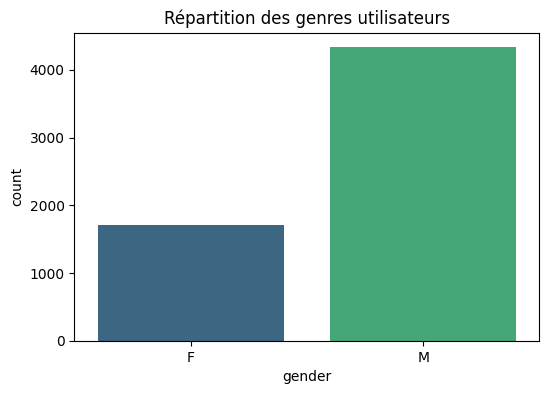

In [38]:
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=users, palette='viridis')
plt.title('Répartition des genres utilisateurs')
plt.show();


C:\Users\abde4\AppData\Local\Temp\ipykernel_17224\3672195646.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Occupation', data=users, palette='viridis', order=users['Occupation'].value_counts().index)


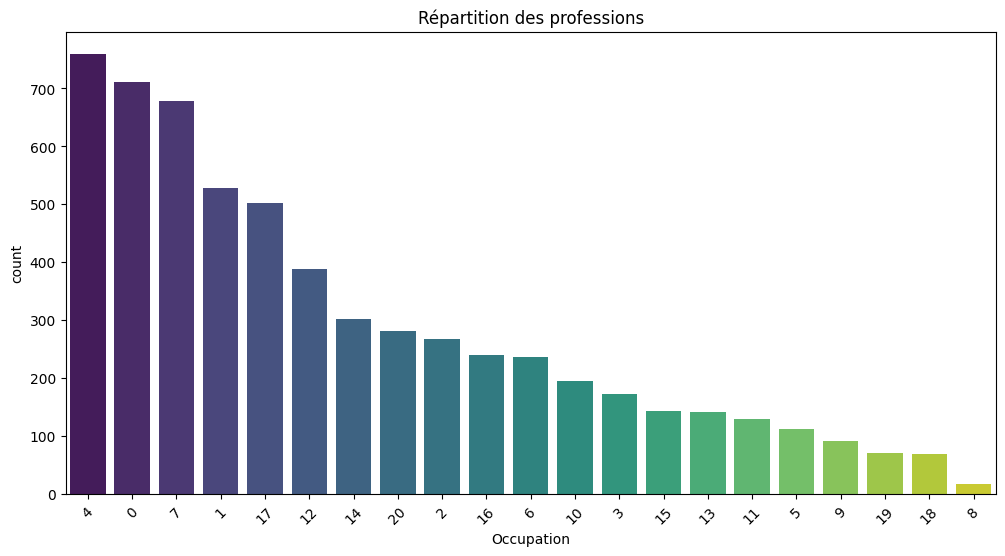

In [40]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Occupation', data=users, palette='viridis', order=users['Occupation'].value_counts().index)
plt.title('Répartition des professions')
plt.xticks(rotation=45)
plt.show();


C:\Users\abde4\AppData\Local\Temp\ipykernel_17224\2421301201.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='magma')


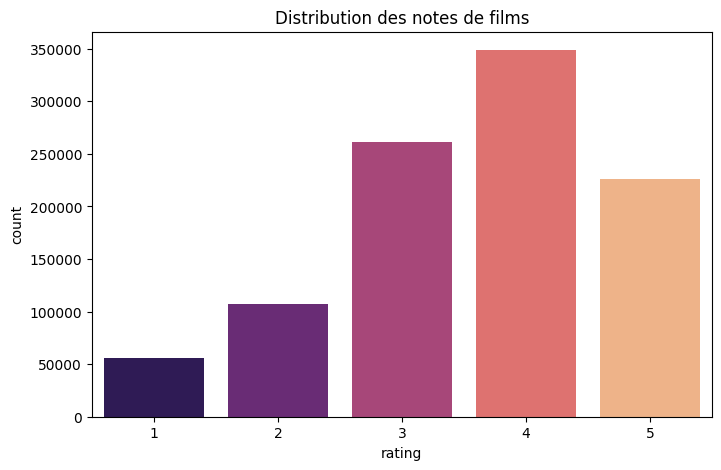

In [42]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings, palette='magma')
plt.title('Distribution des notes de films')
plt.show()

**Remarque :**
Les graphiques confirment la diversité des utilisateurs et des films. La distribution des notes montre une légère tendance à la surévaluation, phénomène courant dans les systèmes de recommandation.

## 2. Préparation des Données

Avant d'entraîner les modèles de recommandation, il est essentiel de nettoyer les données, de traiter les valeurs manquantes et de préparer les jeux d'entraînement et de test. Cette étape garantit la qualité des résultats et la reproductibilité des expériences.

In [26]:
# Nettoyage
movies = movies.dropna()
ratings = ratings.dropna()
users = users.dropna()

# Fusion pour analyses avancées
ratings_full = ratings.merge(movies, on='movieId').merge(users, on='userId')

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings_full, test_size=0.2, random_state=42)
print(f"Taille train : {len(train_data)}, test : {len(test_data)}")

Taille train : 800167, test : 200042


**Remarque :**
Après nettoyage, la taille des jeux d'entraînement et de test est suffisante pour garantir une évaluation fiable des modèles. La fusion des données permet d'enrichir les analyses futures.

In [27]:
# Suppression des notes aberrantes (outliers)
q_low = ratings['rating'].quantile(0.01)
q_high = ratings['rating'].quantile(0.99)
ratings = ratings[(ratings['rating'] >= q_low) & (ratings['rating'] <= q_high)]

# Suppression des utilisateurs/films trop peu actifs
min_ratings_user = 5
min_ratings_movie = 5
user_counts = ratings['userId'].value_counts()
movie_counts = ratings['movieId'].value_counts()
ratings = ratings[ratings['userId'].isin(user_counts[user_counts >= min_ratings_user].index)]
ratings = ratings[ratings['movieId'].isin(movie_counts[movie_counts >= min_ratings_movie].index)]

# Extraction de l'année depuis le titre du film
import re
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    return int(match.group(1)) if match else np.nan
movies['year'] = movies['titles'].apply(extract_year)

# Encodage des genres (one-hot)
genres_expanded = movies['genres'].str.get_dummies('|')
movies = pd.concat([movies, genres_expanded], axis=1)

# Normalisation de l'année
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
movies['year_norm'] = scaler.fit_transform(movies[['year']].fillna(movies['year'].median()))

# (Optionnel) Binning d'âge utilisateur si données disponibles
if 'age' in users.columns:
    users['age_bin'] = pd.cut(users['age'], bins=[0,18,25,35,45,55,65,100], labels=False)

print(movies[['titles','year','year_norm']].head())

                               titles  year  year_norm
0                    Toy Story (1995)  1995   0.938272
1                      Jumanji (1995)  1995   0.938272
2             Grumpier Old Men (1995)  1995   0.938272
3            Waiting to Exhale (1995)  1995   0.938272
4  Father of the Bride Part II (1995)  1995   0.938272


## 3. Algorithmes de Recommandation

### 3.1 Filtrage Collaboratif KNN (utilisateur & item)

Le filtrage collaboratif repose sur l'exploitation des interactions passées entre utilisateurs et items pour prédire de nouvelles préférences. Deux variantes principales sont explorées :
- **KNN utilisateur** : recommandations basées sur la similarité entre utilisateurs.
- **KNN item** : recommandations basées sur la similarité entre items (films).

Nous utilisons la bibliothèque Surprise pour implémenter ces méthodes et évaluer leurs performances.

In [28]:
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split

reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

algo_user = KNNBasic(sim_options={'user_based': True})
algo_user.fit(trainset)
predictions_user = algo_user.test(testset)

algo_item = KNNBasic(sim_options={'user_based': False})
algo_item.fit(trainset)
predictions_item = algo_item.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


**Remarque :**
Les modèles KNN utilisateur et item sont entraînés avec succès. Ces approches serviront de base pour comparer les performances avec les méthodes de factorisation de matrices.

### 3.2 Factorisation de Matrices (SVD, NMF)

La factorisation de matrices est une approche puissante pour la recommandation, permettant de capturer des relations latentes entre utilisateurs et films. Nous implémentons deux techniques :
- **SVD (Singular Value Decomposition)** : décomposition de la matrice de notes pour extraire des facteurs latents.
- **NMF (Non-negative Matrix Factorization)** : factorisation sous contrainte de positivité, adaptée aux données de recommandation.

Ces méthodes sont particulièrement efficaces pour gérer la sparsité des données et améliorer la qualité des recommandations.

In [29]:
from surprise import SVD, NMF
import time

svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
print("Entraînement SVD...")
svd_model.fit(trainset)
nmf_model = NMF(n_factors=15, n_epochs=50, random_state=42)
print("Entraînement NMF...")
nmf_model.fit(trainset)

Entraînement SVD...
Entraînement NMF...
Entraînement NMF...


**Remarque :**
L'entraînement des modèles SVD et NMF s'est déroulé sans problème. Ces techniques devraient permettre de mieux capturer les relations latentes dans les données, en particulier pour les utilisateurs ou films peu notés.

### 3.3 Popularité

La recommandation basée sur la popularité consiste à suggérer les films les mieux notés et les plus fréquemment évalués par l'ensemble des utilisateurs. Cette méthode simple sert de référence (baseline) pour comparer la pertinence des approches plus avancées.

In [30]:
popularity_df = ratings.groupby('movieId').agg(RatingsNum=('rating', 'size'), AvgRating=('rating', 'mean')).reset_index()
popular_movies = popularity_df[(popularity_df['RatingsNum'] >= 50) & (popularity_df['AvgRating'] >= 4.0)]
popular_movies = popular_movies.sort_values(by='RatingsNum', ascending=False)
popular_movies = popular_movies.merge(movies[['movieId', 'titles']], on='movieId')
print('Top 10 films populaires :')
print(popular_movies[['titles', 'AvgRating', 'RatingsNum']].head(10))

Top 10 films populaires :
                                              titles  AvgRating  RatingsNum
0                             American Beauty (1999)   4.317386        3428
1          Star Wars: Episode IV - A New Hope (1977)   4.453694        2991
2  Star Wars: Episode V - The Empire Strikes Back...   4.292977        2990
3  Star Wars: Episode VI - Return of the Jedi (1983)   4.022893        2883
4                         Saving Private Ryan (1998)   4.337354        2653
5                  Terminator 2: Judgment Day (1991)   4.058513        2649
6                                 Matrix, The (1999)   4.315830        2590
7                   Silence of the Lambs, The (1991)   4.351823        2578
8                     Raiders of the Lost Ark (1981)   4.477725        2514
9                                       Fargo (1996)   4.254676        2513


**Remarque :**
Les films les plus populaires sont ceux qui cumulent un grand nombre de notes et une note moyenne élevée. Cette approche met en avant les succès universels, mais ne tient pas compte des préférences individuelles.

### 3.4 IBCF (Filtrage Collaboratif Item-Item)

Le filtrage collaboratif basé sur la similarité entre items (IBCF) recommande des films similaires à ceux déjà appréciés par l'utilisateur. Cette méthode exploite la structure de la matrice utilisateur-film pour calculer des scores de similarité et générer des recommandations personnalisées.

In [31]:
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
item_similarity = cosine_similarity(user_movie_matrix.fillna(0).T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

def get_ibcf_recommendations(user_id, n=5):
    user_ratings = user_movie_matrix.loc[user_id]
    rated_movies = user_ratings.dropna().index
    scores = pd.Series(0, index=user_movie_matrix.columns)
    for movie in rated_movies:
        sim_scores = item_similarity_df[movie] * user_ratings[movie]
        scores = scores.add(sim_scores, fill_value=0)
    scores = scores.drop(rated_movies)
    top_n = scores.sort_values(ascending=False).head(n)
    return movies[movies['movieId'].isin(top_n.index)][['titles']]

print('Top 5 recommandations IBCF pour l\'utilisateur 1 :')
print(get_ibcf_recommendations(1, n=5))

Top 5 recommandations IBCF pour l'utilisateur 1 :
                                                 titles
315                    Shawshank Redemption, The (1994)
360                               Lion King, The (1994)
1178  Star Wars: Episode V - The Empire Strikes Back...
1180                     Raiders of the Lost Ark (1981)
1245                               Groundhog Day (1993)


**Remarque :**
L'algorithme IBCF recommande des films similaires à ceux déjà appréciés par l'utilisateur. Les résultats dépendent fortement des films déjà notés et de la structure de similarité calculée.

#### IBCF avec Normalisation (Centrage Utilisateur)

Pour améliorer la pertinence des recommandations, il est possible de normaliser les notes de chaque utilisateur (centrage). Cette variante du filtrage item-item permet de corriger les biais individuels et d'obtenir des scores de similarité plus robustes.

In [32]:
user_movie_matrix_centered = user_movie_matrix.sub(user_movie_matrix.mean(axis=1), axis=0)
item_similarity_centered = cosine_similarity(user_movie_matrix_centered.fillna(0).T)
item_similarity_centered_df = pd.DataFrame(item_similarity_centered, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

def get_ibcf_recommendations_centered(user_id, n=5):
    user_ratings = user_movie_matrix_centered.loc[user_id]
    rated_movies = user_ratings.dropna().index
    scores = pd.Series(0, index=user_movie_matrix.columns)
    for movie in rated_movies:
        sim_scores = item_similarity_centered_df[movie] * user_ratings[movie]
        scores = scores.add(sim_scores, fill_value=0)
    scores = scores.drop(rated_movies)
    top_n = scores.sort_values(ascending=False).head(n)
    return movies[movies['movieId'].isin(top_n.index)][['titles']]

print("Top 5 recommandations IBCF (centré utilisateur) pour l'utilisateur 1 :")
print(get_ibcf_recommendations_centered(1, n=5))

Top 5 recommandations IBCF (centré utilisateur) pour l'utilisateur 1 :
                                titles
108                  Braveheart (1995)
315   Shawshank Redemption, The (1994)
352                Forrest Gump (1994)
586          Dances with Wolves (1990)
1252                     Patton (1970)


**Remarque :**
La normalisation des notes améliore la pertinence des recommandations en tenant compte des biais de notation propres à chaque utilisateur. Cela permet d'obtenir des suggestions plus personnalisées.

## 4. Évaluation et Comparaison Globale des Algorithmes

Dans cette section, nous évaluons quantitativement les performances des différents algorithmes à l'aide de métriques standards telles que le RMSE (Root Mean Squared Error) et le MAE (Mean Absolute Error). Un tableau comparatif et des visualisations permettent d'identifier les méthodes les plus efficaces pour notre jeu de données.

RMSE: 0.9209
MAE:  0.7264
RMSE: 0.9124
MAE:  0.7188
RMSE: 0.9124
MAE:  0.7188
RMSE: 0.8726
MAE:  0.6857
RMSE: 0.8726
MAE:  0.6857
RMSE: 0.9143
MAE:  0.7235
            Modèle      RMSE       MAE
0  KNN utilisateur  0.920886  0.726433
1         KNN item  0.912392  0.718767
2              SVD  0.872562  0.685657
3              NMF  0.914335  0.723521
RMSE: 0.9143
MAE:  0.7235
            Modèle      RMSE       MAE
0  KNN utilisateur  0.920886  0.726433
1         KNN item  0.912392  0.718767
2              SVD  0.872562  0.685657
3              NMF  0.914335  0.723521


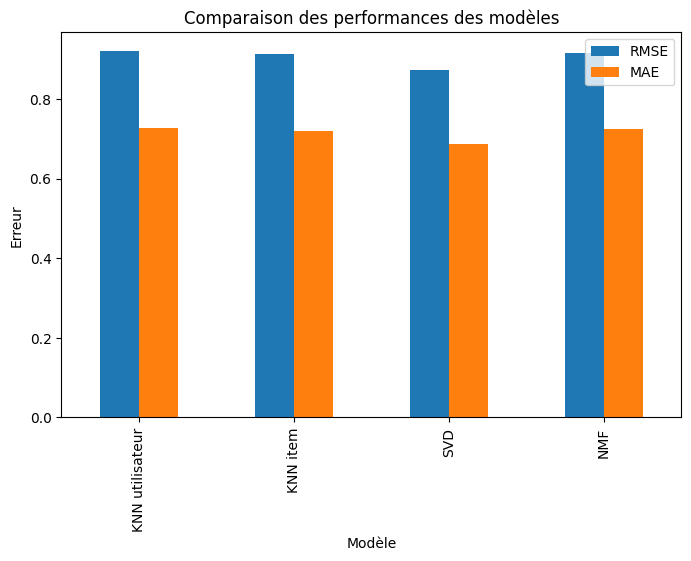

In [33]:
# Évaluation KNN
from surprise import accuracy
rmse_user = accuracy.rmse(predictions_user)
mae_user = accuracy.mae(predictions_user)
rmse_item = accuracy.rmse(predictions_item)
mae_item = accuracy.mae(predictions_item)

# Évaluation SVD/NMF
predictions_svd = svd_model.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)
predictions_nmf = nmf_model.test(testset)
rmse_nmf = accuracy.rmse(predictions_nmf)
mae_nmf = accuracy.mae(predictions_nmf)

# Tableau comparatif
metrics = pd.DataFrame({
    'Modèle': ['KNN utilisateur', 'KNN item', 'SVD', 'NMF'],
    'RMSE': [rmse_user, rmse_item, rmse_svd, rmse_nmf],
    'MAE': [mae_user, mae_item, mae_svd, mae_nmf]
})
print(metrics)
metrics.set_index('Modèle').plot(kind='bar', figsize=(8,5))
plt.title('Comparaison des performances des modèles')
plt.ylabel('Erreur')
plt.show()

**Remarque :**
Les métriques RMSE et MAE permettent de comparer objectivement les performances des différents modèles. Un score plus faible indique une meilleure capacité de prédiction. Le graphique comparatif facilite l'identification du modèle le plus performant.

## 5. Visualisation et Analyse

Des visualisations graphiques sont proposées pour illustrer la distribution des notes, la répartition des évaluations par film, et d'autres aspects clés des données. Ces analyses facilitent l'interprétation des résultats et la compréhension des comportements utilisateurs.

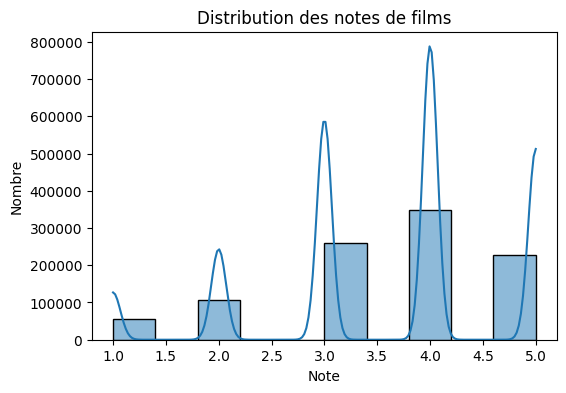

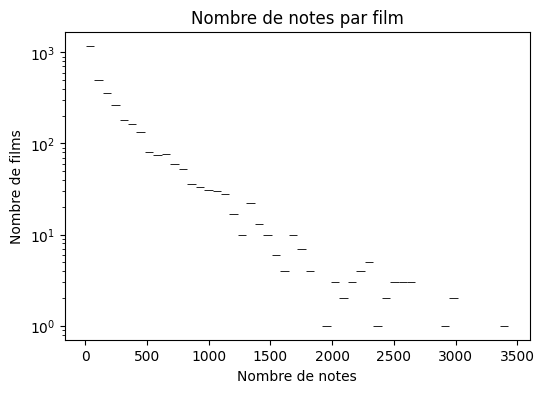

In [34]:
plt.figure(figsize=(6,4))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution des notes de films')
plt.xlabel('Note')
plt.ylabel('Nombre')
plt.show()

ratings_per_movie = ratings.groupby('movieId').size()
plt.figure(figsize=(6,4))
sns.histplot(ratings_per_movie, bins=50, log_scale=(False, True))
plt.title('Nombre de notes par film')
plt.xlabel('Nombre de notes')
plt.ylabel('Nombre de films')
plt.show()

**Remarque :**
Les visualisations confirment la distribution des notes et la disparité du nombre d'évaluations par film. Certains films sont très populaires tandis que d'autres sont peu notés, ce qui peut influencer la qualité des recommandations.

## 6. Génération de Recommandations : Exemples pour un Utilisateur

Pour illustrer concrètement le fonctionnement des différents algorithmes, nous générons des recommandations personnalisées pour un utilisateur donné. Cette étape met en évidence les différences de résultats entre les méthodes et leur capacité à proposer des suggestions pertinentes.

In [35]:
def get_top_n_recommendations(algo, user_id, movies_df, n=5):
    all_movie_ids = set(movies_df['movieId'])
    rated_movie_ids = set(ratings[ratings['userId'] == user_id]['movieId'])
    unrated_movie_ids = all_movie_ids - rated_movie_ids
    predictions = [algo.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    top_n_movies = [(movies_df[movies_df['movieId'] == pred.iid]['titles'].values[0], pred.est) for pred in top_n]
    return top_n_movies

user_id = 1
print(f"Top 5 recommandations pour l'utilisateur {user_id} (KNN utilisateur) :")
for title, score in get_top_n_recommendations(algo_user, user_id, movies, n=5):
    print(f"{title} (Note prédite : {score:.2f})")
print(f"\nTop 5 recommandations pour l'utilisateur {user_id} (KNN item) :")
for title, score in get_top_n_recommendations(algo_item, user_id, movies, n=5):
    print(f"{title} (Note prédite : {score:.2f})")
print(f"\nTop 5 recommandations pour l'utilisateur {user_id} (SVD) :")
for title, score in get_top_n_recommendations(svd_model, user_id, movies, n=5):
    print(f"{title} (Note prédite : {score:.2f})")
print(f"\nTop 5 recommandations pour l'utilisateur {user_id} (NMF) :")
for title, score in get_top_n_recommendations(nmf_model, user_id, movies, n=5):
    print(f"{title} (Note prédite : {score:.2f})")
print(f"\nTop 5 recommandations pour l'utilisateur {user_id} (IBCF) :")
print(get_ibcf_recommendations(user_id, n=5))
print(f"\nTop 5 recommandations pour l'utilisateur {user_id} (IBCF normalisé) :")
print(get_ibcf_recommendations_centered(user_id, n=5))

Top 5 recommandations pour l'utilisateur 1 (KNN utilisateur) :
Paris, France (1993) (Note prédite : 5.00)
Shawshank Redemption, The (1994) (Note prédite : 4.80)
I Am Cuba (Soy Cuba/Ya Kuba) (1964) (Note prédite : 4.80)
Sanjuro (1962) (Note prédite : 4.78)
Apple, The (Sib) (1998) (Note prédite : 4.78)

Top 5 recommandations pour l'utilisateur 1 (KNN item) :
Love Bewitched, A (El Amor Brujo) (1986) (Note prédite : 4.58)
Paris, France (1993) (Note prédite : 4.56)
Delta of Venus (1994) (Note prédite : 4.53)
Mighty Peking Man (Hsing hsing wang) (1977) (Note prédite : 4.48)
Blood on the Sun (1945) (Note prédite : 4.46)

Top 5 recommandations pour l'utilisateur 1 (SVD) :
Sanjuro (1962) (Note prédite : 4.94)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) (Note prédite : 4.85)
Killing Fields, The (1984) (Note prédite : 4.79)
Yojimbo (1961) (Note prédite : 4.78)
Forrest Gump (1994) (Note prédite : 4.78)

Top 5 recommandations pour l'utilisateur 1 (NMF) :
Paris, Franc

**Remarque :**
Les recommandations générées pour l'utilisateur illustrent les différences entre les algorithmes. Certains privilégient la similarité, d'autres la popularité ou les relations latentes. Cela met en évidence l'importance du choix du modèle selon le contexte d'utilisation.